In [315]:
# From this tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
from __future__ import print_function, division
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

# import the required libraries
import glob
import os
os.sys.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from IPython.display import Image as Image2
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [316]:
train_raw = pd.read_csv('training.csv')
final_test_raw = pd.read_csv('test.csv')

print(train_raw.shape)
train_raw = train_raw.dropna()
train_raw = train_raw.reset_index(drop=True)
print(train_raw.shape)

train, test = train_test_split(train_raw, test_size=0.2, random_state=0)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
print(train.shape)
print(test.shape)

(7049, 31)
(2140, 31)
(1712, 31)
(428, 31)


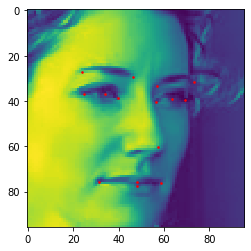

In [319]:
image_num = 428

selected_pix = train['Image'][image_num]
key_pts = train.iloc[image_num, 0:30].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)
# print('Pixels: ', selected_pix)
# print('Landmarks shape: ', key_pts.shape)
# print('First 4 key pts: {}'.format(key_pts[:4]))

# # note to self: pixels are one 0 to 255 value (instead of 3 values) because it is grayscale
image_string = selected_pix.split(' ') #pixels are separated by spaces.
image_data = np.asarray(image_string, dtype=np.uint8).reshape(96,96)
img = Image.fromarray(image_data) #final image

def show_keypoints(image, key_pts):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_keypoints(img, key_pts)
plt.show()

In [320]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe: Dataframe to be used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        # no image name in our code
        selected_pix = self.key_pts_frame['Image'][idx]
        image_string = selected_pix.split(' ') #pixels are separated by spaces.
        image_data = np.asarray(image_string, dtype=np.uint8).reshape(96,96)
        image = Image.fromarray(image_data) #final image
        
        key_pts = self.key_pts_frame.iloc[idx, 0:30].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [321]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(dataframe=train)

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  1712


427
0 (15, 2)


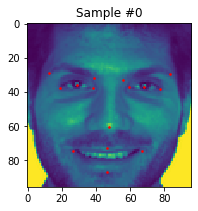

1370
1 (15, 2)


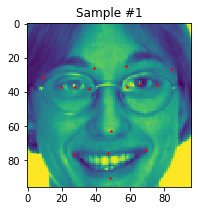

378
2 (15, 2)


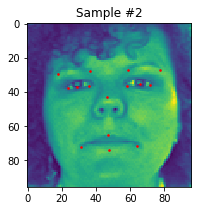

In [322]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    print(rand_i)
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])
    
# From looking at some of these, it's obvious we have missing keypoints in the training data (might need to clean that up)

In [323]:
class Normalize(object):
    """Normalize the grayscale range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # guide does math here differently
        # if every image is 96x96, we should be able to subtract 48 from x and y to have center of image be (0,0) 
        # Then highest value we could have is 48, so we divide by 48 to make that = to 1
        key_pts_copy = (key_pts_copy - 48)/48


        return {'image': image_copy, 'keypoints': key_pts_copy}
    
# skipping Rescale and RandomCrop classes because our images are already standardized 96x96 pixels

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [324]:
# define the data transform
data_transform = transforms.Compose([Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(dataframe=train,
                                             transform=data_transform)

In [325]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  1712
0 torch.Size([1, 96, 96]) torch.Size([15, 2])
1 torch.Size([1, 96, 96]) torch.Size([15, 2])
2 torch.Size([1, 96, 96]) torch.Size([15, 2])
3 torch.Size([1, 96, 96]) torch.Size([15, 2])
4 torch.Size([1, 96, 96]) torch.Size([15, 2])


In [326]:
# model
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        #obejctive is to bring down the image size to single unit-->
        #here given image size is 96x96px
        self.conv1 = nn.Conv2d(1, 32, 5)
        #96--> 96-5+1=92
        self.pool1 = nn.MaxPool2d(2, 2)
        #92/2=46 ...(32,46,46)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        #46--> 46-3+1=44
        self.pool2 = nn.MaxPool2d(2, 2)
        #44/2=22
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        #22-->22-3+1=20
        self.pool3 = nn.MaxPool2d(2, 2)
        #20/2=10
        
        self.conv4 = nn.Conv2d(128, 256, 3)
        #10-->10-3+1=8
        self.pool4 = nn.MaxPool2d(2, 2)
        #8/2=4
        
        self.conv5 = nn.Conv2d(256,512,1)
        #4-->4-1+1=4
        self.pool5 = nn.MaxPool2d(2,2)
        #4/2=2
        
        #2x2x512
        self.fc1 = nn.Linear(2*2*512 , 1024)
#         self.fc2 = nn.Linear(1024,1024)
#         doing 30 keypoints here (15*2)
        self.fc2 = nn.Linear(1024,30)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)
        #self.fc2_drop = nn.Dropout(p=.5)
            
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        

        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        x = self.drop5(self.pool5(F.relu(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = self.drop6(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x

# instantiate the net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop

In [327]:
assert(data_transform is not None), 'Define a data_transform'

In [328]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [329]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(dataframe=test,
                                             transform=data_transform)

In [330]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [331]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 15 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 15, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [332]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 15, 2])
torch.Size([10, 15, 2])


In [333]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=10, marker='.', c='r')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=10, marker='.', c='g')

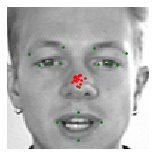

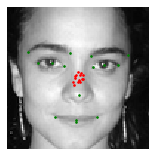

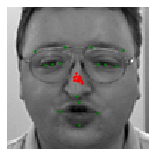

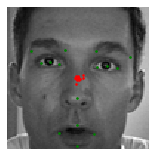

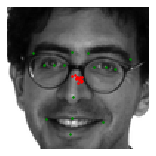

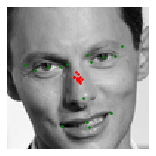

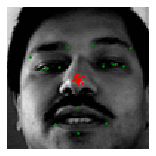

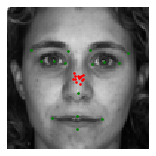

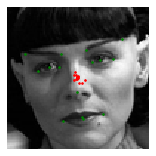

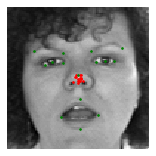

In [334]:

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(30,30))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*48.0+48
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*48.0+48
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [335]:
## TODO: Define the loss and optimization
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [336]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            #output_pts = output_pts.type(torch.FloatTensor)
            #print(output_pts.type)
            #print(key_pts.type)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [340]:
# train your network
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

# start training
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 6.716637453064322e-05
Epoch: 1, Batch: 20, Avg. Loss: 6.653308495879173e-05
Epoch: 1, Batch: 30, Avg. Loss: 5.9497451409697534e-05
Epoch: 1, Batch: 40, Avg. Loss: 6.240835878998041e-05
Epoch: 1, Batch: 50, Avg. Loss: 7.38674714230001e-05
Epoch: 1, Batch: 60, Avg. Loss: 6.334399012848734e-05
Epoch: 1, Batch: 70, Avg. Loss: 6.005978025496006e-05
Epoch: 1, Batch: 80, Avg. Loss: 7.139320438727737e-05
Epoch: 1, Batch: 90, Avg. Loss: 6.953036971390247e-05
Epoch: 1, Batch: 100, Avg. Loss: 6.556185591034591e-05
Epoch: 1, Batch: 110, Avg. Loss: 5.763825215399265e-05
Epoch: 1, Batch: 120, Avg. Loss: 6.894075451418758e-05
Epoch: 1, Batch: 130, Avg. Loss: 6.383695034310222e-05
Epoch: 1, Batch: 140, Avg. Loss: 5.9259919449687003e-05
Epoch: 1, Batch: 150, Avg. Loss: 6.233531143516302e-05
Epoch: 1, Batch: 160, Avg. Loss: 5.1494532264769076e-05
Epoch: 1, Batch: 170, Avg. Loss: 5.180527665652335e-05
Epoch: 2, Batch: 10, Avg. Loss: 6.449372135102749e-05
Epoch: 2, Batch: 2

In [341]:
# get a sample of test data again
# net_sample_output has the test data hardcoded into it (that's why it takes no arguments)
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 96, 96])
torch.Size([10, 15, 2])
torch.Size([10, 15, 2])


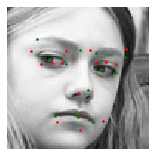

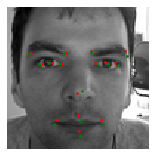

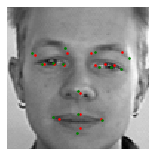

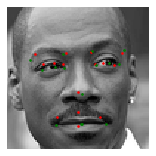

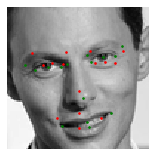

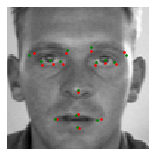

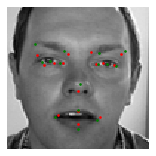

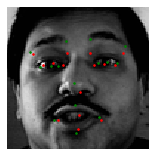

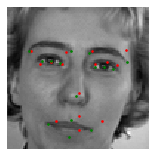

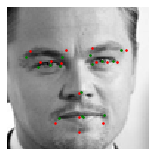

In [342]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, gt_pts)